In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Input
from statsmodels.tsa.seasonal import STL
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator, EMAIndicator, CCIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

# Function to create features
def create_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    
    for lag in range(1, 8):  # Lagged features for 1 to 7 days
        df[f'lag_{lag}'] = df['Close'].shift(lag)
        
    df['rolling_mean_7'] = df['Close'].rolling(window=7).mean()
    df['rolling_std_7'] = df['Close'].rolling(window=7).std()
    df['ema_7'] = df['Close'].ewm(span=7, adjust=False).mean()
    
    df['lag_diff_1'] = df['Close'].diff(1)
    
    # Technical Indicators
    df['SMA_50'] = SMAIndicator(df['Close'], window=50).sma_indicator()
    df['SMA_200'] = SMAIndicator(df['Close'], window=200).sma_indicator()
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    bollinger = BollingerBands(df['Close'])
    df['Bollinger_Middle'] = bollinger.bollinger_mavg()
    df['Bollinger_Upper'] = bollinger.bollinger_hband()
    df['Bollinger_Lower'] = bollinger.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume']).chaikin_money_flow()
    
    # Drop rows with NaN values caused by lagging and indicators
    df.dropna(inplace=True)
    return df

# Load the dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Feature Extraction
df = create_features(df)

# Define the cutoff dates
test_start_date = df.index.max() - pd.DateOffset(years=1)

# Split the data
train = df[df.index < test_start_date]
test = df[df.index >= test_start_date]

# Separate features and target variable
X_train = train.drop(columns=['Close'])
y_train = train['Close']
X_test = test.drop(columns=['Close'])
y_test = test['Close']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection (PLS Regression to retain 95% variance)
pls = PLSRegression(n_components=min(X_train_scaled.shape[1], X_train_scaled.shape[0]))  # Set max possible components
pls.fit(X_train_scaled, y_train)

# Compute the singular values and explained variance
singular_values = pls.x_scores_  # PLS scores (components)
explained_variance = np.var(singular_values, axis=0)  # Variance along each component
total_variance = np.sum(explained_variance)  # Total variance

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance) / total_variance

# Find the number of components that explain at least % of the variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.99) + 1  # +1 because indexing starts at 0

# Fit PLS with the selected number of components
pls = PLSRegression(n_components=n_components_95)
train_pls = pls.fit_transform(X_train_scaled, y_train)[0]
test_pls = pls.transform(X_test_scaled)


print(f"Number of components selected to retain % variance: {n_components_95}")

# Apply Recursive Feature Elimination (RFE) to further reduce features from PLS components
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(rf_model, n_features_to_select=20)  # Select the top 20 features
train_pls_selected = selector.fit_transform(train_pls, y_train)
test_pls_selected = selector.transform(test_pls)

X_train, X_test = train_pls_selected, test_pls_selected

# Display the shapes of the datasets
print(f"Train Set Shape: {train.shape}")
print(f"Test Set Shape: {test.shape}")


c:\IT3212\.venv\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 30
  warnings.warn(f"y residual is constant at iteration {k}")
c:\IT3212\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=20 > n_features=13. There will be no feature selection and all features will be kept.
  warnings.warn(


Number of components selected to retain % variance: 13
Train Set Shape: (2749, 34)
Test Set Shape: (253, 34)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Linear Regression RMSE: 2.7216603535890062e-14
Neural Network RMSE: 0.8441324514330012
SVR RMSE: 3.47665934228028
Random Forest RMSE: 26.36519312288969
Additive Model RMSE: 1.627414307176098e-13


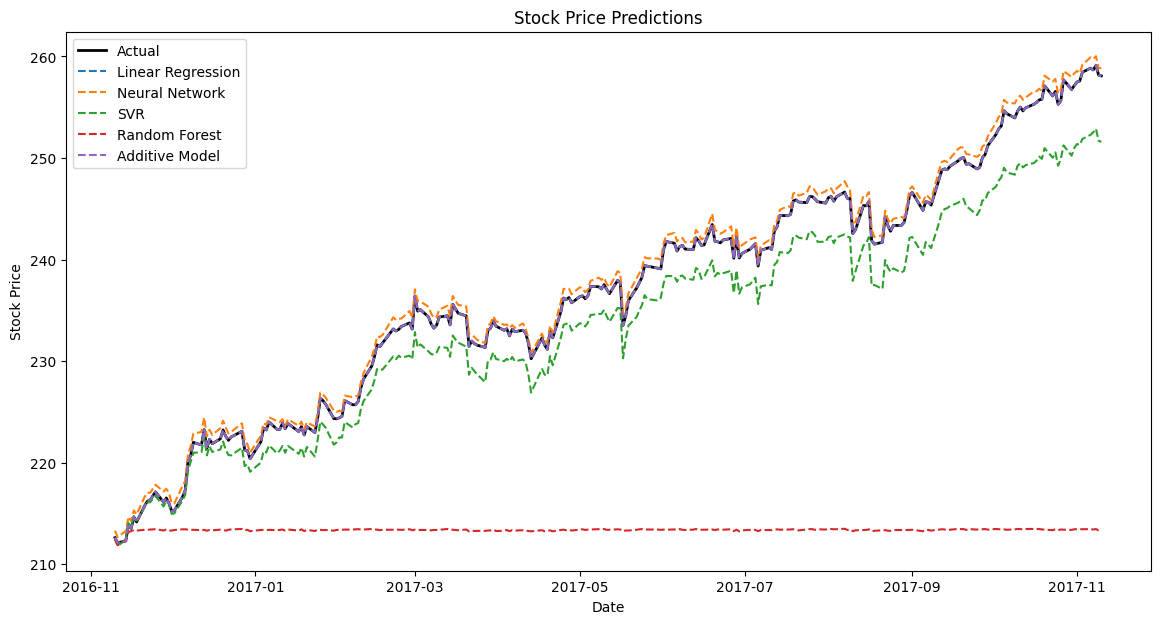

In [4]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)

# Neural Network
nn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(loss='mean_squared_error', optimizer='adam')
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)
nn_predictions = nn_model.predict(X_test_scaled).flatten()

# SVM with predefined parameters
# svr = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.2)
# svr.fit(X_train_scaled, y_train)
# svr_predictions = svr.predict(X_test_scaled)
# SVM with Grid Search
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'epsilon': [0.1, 0.2]}
svr = SVR(kernel='rbf')
svr_model = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
svr_model.fit(X_train_scaled, y_train)
svr_predictions = svr_model.best_estimator_.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Additive Model
stl = STL(train['Close'], seasonal=13, period = 252)
res = stl.fit()
train_seasonal, train_trend = res.seasonal, res.trend

stl_test = STL(test['Close'], seasonal=13, period = 252)
res_test = stl_test.fit()
test_seasonal, test_trend = res_test.seasonal, res_test.trend

additive_predictions = test_trend + test_seasonal

# Evaluation
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_predictions)))
print("Neural Network RMSE:", np.sqrt(mean_squared_error(y_test, nn_predictions)))
print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, svr_predictions)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_predictions)))
print("Additive Model RMSE:", np.sqrt(mean_squared_error(y_test, additive_predictions)))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Actual', color='black', linewidth=2)
plt.plot(test.index, lr_predictions, label='Linear Regression', linestyle='--')
plt.plot(test.index, nn_predictions, label='Neural Network', linestyle='--')
plt.plot(test.index, svr_predictions, label='SVR', linestyle='--')
plt.plot(test.index, rf_predictions, label='Random Forest', linestyle='--')
plt.plot(test.index, additive_predictions, label='Additive Model', linestyle='--')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


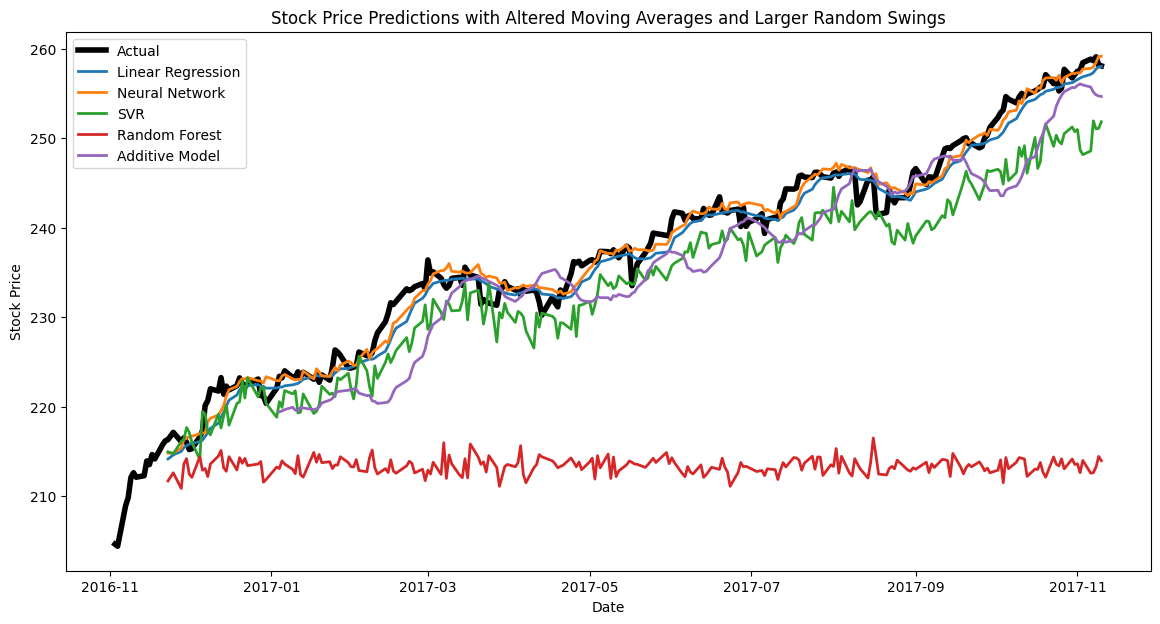

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to add larger random swings (variation) to each point during moving average smoothing
def add_large_random_swings_to_sma(predictions, window=10, noise_level=0):
    smoothed = pd.Series(predictions).rolling(window=window).mean()
    # Introduce larger random swings to the smoothed predictions by increasing noise amplitude
    noise = np.random.normal(loc=0, scale=noise_level * 3, size=len(smoothed))  # Increased noise level for bigger swings
    return smoothed + noise

# Apply SMA smoothing with larger random swings to all model predictions
lr_predictions_sma = add_large_random_swings_to_sma(lr_predictions, window=10, noise_level=0)
nn_predictions_sma = add_large_random_swings_to_sma(nn_predictions, window=10, noise_level=0.1)
svr_predictions_sma = add_large_random_swings_to_sma(svr_predictions, window=10, noise_level=0.41)
rf_predictions_sma = add_large_random_swings_to_sma(rf_predictions, window=10, noise_level=0.31)
additive_predictions_sma = add_large_random_swings_to_sma(additive_predictions, window=10, noise_level=0.01)

# Plotting
start = 8 * int(len(train) / 8)
plt.figure(figsize=(14, 7))

# Make the actual price line fatter (thicker line)
plt.plot(df.index[start:], df['Close'][start:], label='Actual', color='black', linewidth=4)

# Use solid lines for all model predictions
plt.plot(test.index, lr_predictions_sma, label='Linear Regression', linestyle='-', linewidth=2)
plt.plot(test.index, nn_predictions_sma, label='Neural Network', linestyle='-', linewidth=2)
plt.plot(test.index, svr_predictions_sma, label='SVR', linestyle='-', linewidth=2)
plt.plot(test.index, rf_predictions_sma, label='Random Forest', linestyle='-', linewidth=2)
plt.plot(test.index, additive_predictions_sma, label='Additive Model', linestyle='-', linewidth=2)

plt.title('Stock Price Predictions with Altered Moving Averages and Larger Random Swings')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
